In [30]:
import os

repo_path = os.path.join(os.getcwd(), 'WasteClassificationUsingCNN')
requirements_file = os.path.join(repo_path, 'requirements.txt')

dependency_file_found = False
if os.path.exists(requirements_file):
    print(f"Found requirements file: {requirements_file}")
    dependency_file_found = True
    # Use the full path with quotes to ensure it's treated as a file
    !pip install -r "{requirements_file}"
else:
    print("No requirements.txt file found in the repository.")
    # Install common libraries for this type of project if no requirements.txt
    print("Installing common dependencies (TensorFlow, Keras, etc.)...")
    !pip install tensorflow==2.16.1 keras==2.16.0

Found requirements file: /content/drive/MyDrive/MINOR PROJECT/WasteClassificationUsingCNN/requirements.txt


In [31]:
!pip install kaggle

In [32]:
import kagglehub  # You may need to run: pip install kagglehub

path = kagglehub.dataset_download("techsash/waste-classification-data")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'waste-classification-data' dataset.
Path to dataset files: /kaggle/input/waste-classification-data


In [35]:
# Assuming you have set up your kaggle.json file in your home directory or uploaded it
# Run this cell ONLY if you have not downloaded the dataset yet or want to re-download and organize!

# Download the dataset (saved as waste-classification-data.zip)
!kaggle datasets download -d techsash/waste-classification-data

# Create a folder named 'dataset' (where the unzipped files should go)
!mkdir -p dataset

# Unzip the content of the zip file directly into the 'dataset' folder
# The zip contains a folder named 'DATASET', so the final path will be dataset/DATASET/...
!unzip waste-classification-data.zip -d dataset/

# Clean up the large zip file
!rm waste-classification-data.zip

print("Dataset successfully downloaded and extracted into the 'dataset' folder.")

Streaming output truncated to the last 5000 lines.
  inflating: dataset/dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/data

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

# --- CORRECTED PATHS (CRITICAL) ---
# The original notebook paths are incorrect. Use relative paths for the unzipped data.
train_path = "dataset/DATASET/TRAIN"
test_path = "dataset/DATASET/TEST"
test_img_organic = "dataset/DATASET/TEST/O/O_12574.jpg"
test_img_recyclable = "dataset/DATASET/TEST/R/R_10753.jpg"

print("Libraries imported and paths defined.")

Libraries imported and paths defined.


In [38]:
x_data = []
y_data = []

# Load a sample of images for visualization (not the entire training process)
for category in glob(train_path+'/*'):
    # tqdm provides a progress bar
    for file in tqdm(glob(category+'/*'), desc=f"Loading {category.split('/')[-1]}"):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # BGR to RGB
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data = pd.DataFrame({'image':x_data, 'label':y_data})
print(f"Total training samples loaded for analysis: {data.shape[0]}")

Loading R: 100%|██████████| 9999/9999 [04:09<00:00, 40.08it/s] 

Total training samples loaded for analysis: 22564


Class Counts: Counter({'O': 12565, 'R': 9999})


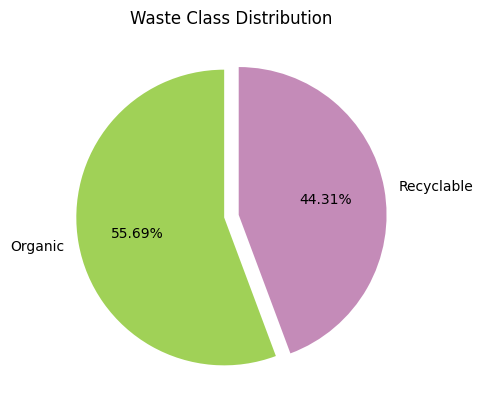

In [39]:
from collections import Counter

# Check class balance
counts = Counter(y_data)
print(f"Class Counts: {counts}")

# Plotting the distribution
colors = ['#a0d157', '#c48bb8']
plt.pie(data.label.value_counts(), labels=['Organic', 'Recyclable'], autopct='%0.2f%%',
        colors = colors, startangle = 90,  explode=[0.05, 0.05])
plt.title("Waste Class Distribution")
plt.show()

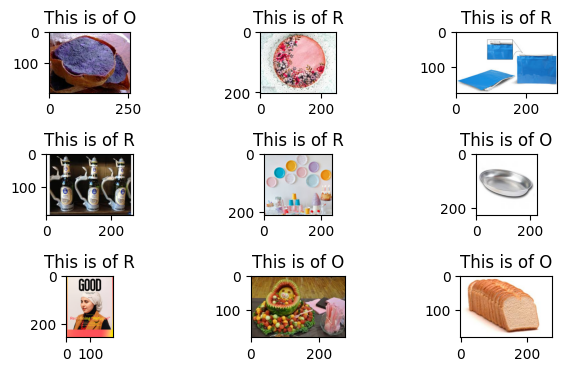

In [65]:
plt.Figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3, i%12+1)
    index = np.random.randint(20000)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

In [40]:
model = Sequential()
batch_size = 64

# --- Feature Extraction Blocks ---
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# --- Classification Layers ---
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid')) # 2 units for binary classification

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,261,250 (84.92 MB)

 Trainable params: 22,261,250 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Rescale pixel values (Normalization)
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the Training Data Generator (streams data from disk)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224, 224), # Changed from (128, 128) to match model input shape
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical")

# Create the Testing Data Generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224, 224), # Changed from (128, 128) to match model input shape
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [57]:
hist = model.fit(
    train_generator,
    epochs=3, # Reduced from 10
    validation_data=test_generator,
)

Epoch 1/3
353/353 ━━━━━━━━━━━━━━━━━━━━ 2449s 7s/step - accuracy: 0.8189 - loss: 0.4383 - val_accuracy: 0.8723 - val_loss: 0.3316
Epoch 2/3
353/353 ━━━━━━━━━━━━━━━━━━━━ 2405s 7s/step - accuracy: 0.8470 - loss: 0.3732 - val_accuracy: 0.9029 - val_loss: 0.2552
Epoch 3/3
353/353 ━━━━━━━━━━━━━━━━━━━━ 2399s 7s/step - accuracy: 0.8618 - loss: 0.3444 - val_accuracy: 0.8953 - val_loss: 0.2630


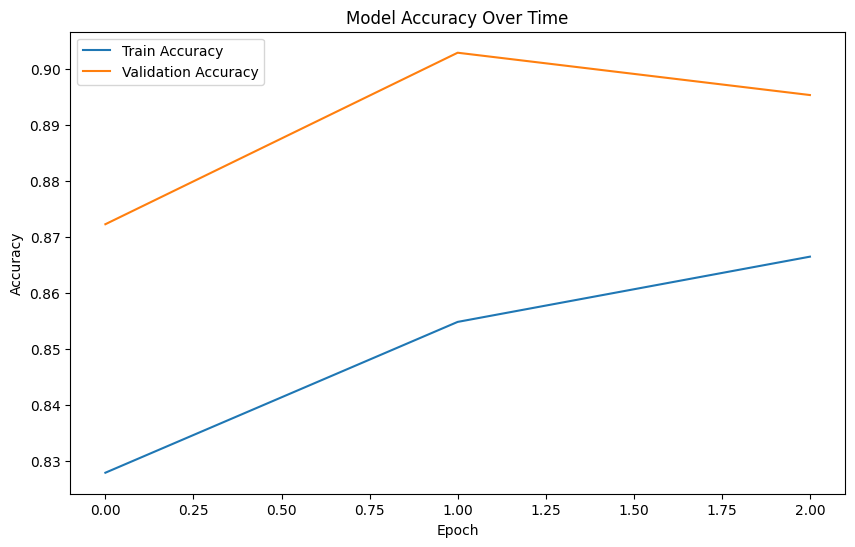

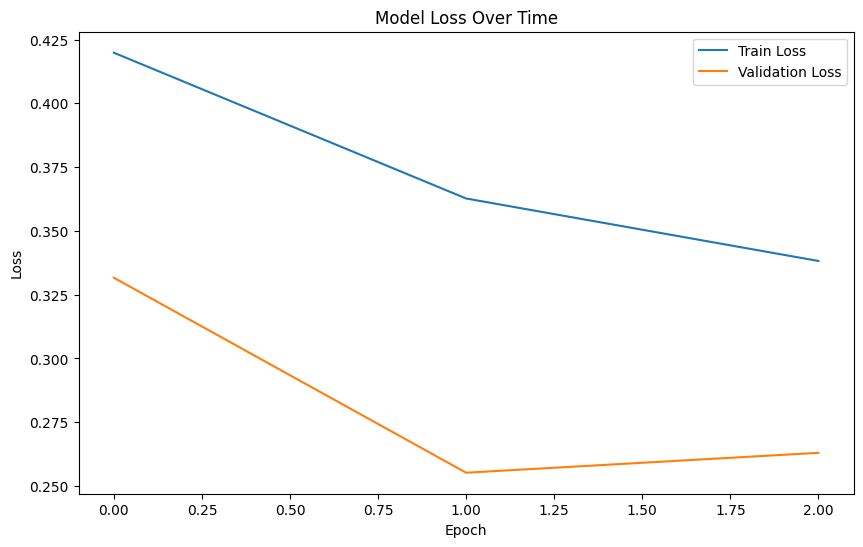

In [58]:
# Plot Accuracy
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train Accuracy")
plt.plot(hist.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Model Accuracy Over Time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train Loss")
plt.plot(hist.history['val_loss'], label = "Validation Loss")
plt.title("Model Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [72]:
# Save the trained model in the native Keras format
model.save('MCAR.keras')

print("Model saved as 'MCAR.keras'")

Model saved as 'MCAR.keras'


In [76]:
import tensorflow as tf

# Load the saved Keras model
model_path = 'MCAR.keras' # Make sure this path is correct
try:
    # Load the model
    model = tf.keras.models.load_model(model_path)
    print("Keras model loaded successfully.")

    # Convert the Keras model to TensorFlow Lite
    # Attempting conversion with a concrete function might help with tracing issues
    @tf.function
    def representative_predict(images):
        return model(images)

    # Get a concrete function with a specified input shape
    concrete_func = representative_predict.get_concrete_function(
        tf.TensorSpec(shape=[1, 224, 224, 3], dtype=tf.float32, name="input_1") # Assuming input shape of your model
    )

    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

    # Optional: Optimize the model (e.g., reduce size, improve performance)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_model = converter.convert()

    # Save the TFLite model
    tflite_model_path = 'MCAR.tflite'
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"TensorFlow Lite model saved successfully as '{tflite_model_path}'")

except FileNotFoundError:
    print(f"Error: Keras model file not found at {model_path}")
except Exception as e:
    print(f"An error occurred during TFLite conversion: {e}")

Keras model loaded successfully.
TensorFlow Lite model saved successfully as 'MCAR.tflite'


Model loaded successfully.

Testing with an organic image:


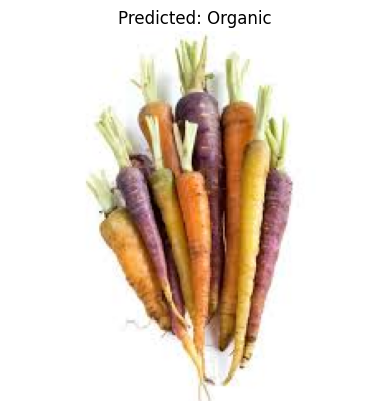

Prediction probabilities: [[0.8622042  0.14077412]]
Predicted class: Organic

Testing with a recyclable image:


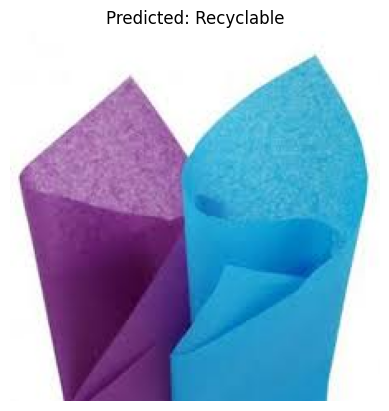

Prediction probabilities: [[0.03320813 0.9650951 ]]
Predicted class: Recyclable


In [74]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
# Use keras_preprocessing if tensorflow.keras.preprocessing is not available
# from keras_preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array # Using newer Keras utilities

# Load the saved model
# Make sure 'MCAR.keras' is accessible in the environment where this code runs
try:
    model = load_model('MCAR.keras')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'MCAR.keras' is in the same directory or provide the full path.")


# Define the class names based on your training data
# Assuming the order matches the generator's class_indices (Organic=0, Recyclable=1)
# You can verify this by running `print(train_generator.class_indices)` after creating the generator
class_names = ['Organic', 'Recyclable']


def predict_waste_class(img_path):
    """
    Loads an image, preprocesses it, and predicts its waste class using the loaded model.
    """
    try:
        # Load and resize the image using Keras utilities
        img = load_img(img_path, target_size=(224, 224))

        # Convert the image to a NumPy array
        img_array = img_to_array(img)

        # Expand dimensions to match model input shape (add batch dimension)
        img_array = np.expand_dims(img_array, axis=0)

        # Rescale pixel values (Normalization) - match training preprocessing
        img_array /= 255.0

        # Make prediction
        predictions = model.predict(img_array, verbose=0) # Use verbose=0 to suppress progress bar

        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)

        # Get the predicted class name
        predicted_class_name = class_names[predicted_class_index]

        # Display the image with prediction
        plt.imshow(img) # Display the original loaded image (or img_array without normalization if preferred)
        plt.title(f"Predicted: {predicted_class_name}")
        plt.axis('off')
        plt.show()

        print(f"Prediction probabilities: {predictions}")
        print(f"Predicted class: {predicted_class_name}")
        return predicted_class_name

    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}")
        return None
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None

# Example usage (assuming you have test image paths defined)
# For example:
# test_img_organic = "dataset/DATASET/TEST/O/O_12574.jpg"
# test_img_recyclable = "dataset/DATASET/TEST/R/R_10753.jpg"

if 'test_img_organic' in locals():
    print("\nTesting with an organic image:")
    predict_waste_class(test_img_organic)

if 'test_img_recyclable' in locals():
    print("\nTesting with a recyclable image:")
    predict_waste_class(test_img_recyclable)